# Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [ ]:
# Collecting Words
path = '/content/drive/MyDrive/Colab Notebooks/AndrejKarpathy_NN_Hero/names.txt'
words = open(path, 'r').read().splitlines()

# Mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3 # number of characters as input
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# Split the dataset (train: 80%, dev: 10%, test:10%)
rs = 2147483647
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.8, random_state=rs, shuffle=True)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, train_size=0.5, random_state=rs, shuffle=True)

# Excercise 1: Set all weights and biases to zero

E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that
+ 1) the network trains just fine or
+ 2) the network doesn't train at all, but actually it is
+ 3) the network trains but only partially, and achieves a pretty bad final performance.

Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [ ]:
# Initializing parameters
g = torch.Generator().manual_seed(2147483647)
n_emb = 10
n_h = 200

C = torch.randn((27, n_emb), generator=g)
w1 = torch.zeros(( n_emb * block_size, n_h))
b1 = torch.zeros((n_h))
w2 = torch.zeros((n_h, 27))
b2 = torch.zeros((27))

params = [C, w1, b1, w2, b2]
for p in params:
    p.requires_grad = True

print(sum(p.nelement() for p in params)) # total params

11897


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    emb_cat = emb.view(emb.shape[0], -1) # concatenated embeds
    h_preact = emb_cat @ w1 + b1 # pre activation
    h = torch.tanh(h_preact) # activation of hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())
print("Final Loss: ", loss.item())

Loss on iteration 0: 3.295837163925171 | Learning Rate: 0.1
Loss on iteration 10000: 2.98496675491333 | Learning Rate: 0.1
Loss on iteration 20000: 2.768519401550293 | Learning Rate: 0.1
Loss on iteration 30000: 2.9385650157928467 | Learning Rate: 0.1
Loss on iteration 40000: 2.8508875370025635 | Learning Rate: 0.1
Loss on iteration 50000: 2.933950662612915 | Learning Rate: 0.1
Loss on iteration 60000: 2.830411911010742 | Learning Rate: 0.1
Loss on iteration 70000: 3.030425786972046 | Learning Rate: 0.1
Loss on iteration 80000: 2.737560510635376 | Learning Rate: 0.1
Loss on iteration 90000: 2.7670984268188477 | Learning Rate: 0.1
Loss on iteration 100000: 3.006406545639038 | Learning Rate: 0.01
Loss on iteration 110000: 2.6482796669006348 | Learning Rate: 0.01
Loss on iteration 120000: 3.0532796382904053 | Learning Rate: 0.01
Loss on iteration 130000: 3.096428155899048 | Learning Rate: 0.01
Loss on iteration 140000: 2.6905555725097656 | Learning Rate: 0.01
Loss on iteration 150000: 2.8

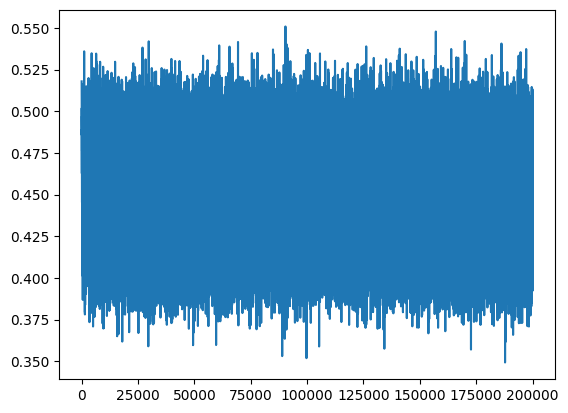

In [ ]:
plt.plot(lossi)

In [ ]:
# DEV & TEST LOSS

@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    h = torch.tanh(emb.view(x.shape[0], -1) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.836271286010742
test 2.8228952884674072


In [ ]:
# CONCLUSION: The network trained partially, maybe more iterations would solve this
# More iterations didn't help

# Excercise 2: Folding the Batchnorm Layer into Linear Layer

E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time.

Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm.

Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.


## Classes

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Working

In [ ]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

16424


In [ ]:
g = torch.Generator().manual_seed(2147483647)
batch_size = 32
itrns = 200000

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    emb = C[Xb] # embed lookup
    x = emb.view(emb.shape[0], -1)
    for layer in layers: # MLP
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.15 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.331695556640625 | Learning Rate: 0.15
Loss on iteration 10000: 2.4977951049804688 | Learning Rate: 0.15
Loss on iteration 20000: 2.2042691707611084 | Learning Rate: 0.15
Loss on iteration 30000: 2.156787395477295 | Learning Rate: 0.15
Loss on iteration 40000: 1.9411007165908813 | Learning Rate: 0.15
Loss on iteration 50000: 2.1103522777557373 | Learning Rate: 0.15
Loss on iteration 60000: 2.120114803314209 | Learning Rate: 0.15
Loss on iteration 70000: 2.3726634979248047 | Learning Rate: 0.15
Loss on iteration 80000: 2.1173620223999023 | Learning Rate: 0.15
Loss on iteration 90000: 2.004641056060791 | Learning Rate: 0.15
Loss on iteration 100000: 2.1450388431549072 | Learning Rate: 0.15
Loss on iteration 110000: 2.161019802093506 | Learning Rate: 0.15
Loss on iteration 120000: 2.1925976276397705 | Learning Rate: 0.15
Loss on iteration 130000: 2.5124757289886475 | Learning Rate: 0.15
Loss on iteration 140000: 1.9205337762832642 | Learning Rate: 0.15
Loss on iterat

In [ ]:
# DEV & TEST LOSS

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.1083784103393555
test 2.105869770050049


## Folding the Layers

To compute the weights & biases of folded layers:
+ std = torch.sqrt(bn.running_var + bn.eps)  # [features]
+ W_folded = lin.weight * (bn.gamma / std)   # shape: same as lin.weight
+ b_folded = - (bn.running_mean * bn.gamma / std) + bn.beta

If linear layer has bias, then:
+ b_folded = ((lin.bias - bn.running_mean) / std) * bn.gamma + bn.beta

In [ ]:
# FOLDING THE LAYERS

folded_layers = []
i = 0

while i < len(layers):
    lin = layers[i]
    bn = layers[i+1]
    act = layers[i+2] if i+2 < len(layers) and isinstance(layers[i+2], Tanh) else None

    assert isinstance(lin, Linear) and isinstance(bn, BatchNorm1d), "Unexpected layer pattern"

    std = torch.sqrt(bn.running_var.squeeze() + bn.eps)
    W_folded = lin.weight * (bn.gamma / std)
    b_folded = - (bn.running_mean.squeeze() * bn.gamma / std) + bn.beta

    # Create a new Linear layer with folded parameters
    class LinearFolded:
        def __init__(self, weight, bias):
            self.weight = weight
            self.bias = bias
        def __call__(self, x):
            return x @ self.weight + self.bias
        def parameters(self):
            return []

    lin_folded = LinearFolded(W_folded, b_folded)

    folded_layers.append(lin_folded)
    if act is not None:
        folded_layers.append(act)
        i += 3  # skip over Linear, BatchNorm, Tanh
    else:
        i += 2  # final layer might not have Tanh

In [ ]:
folded_layers

In [ ]:
# TESTING IT
# DEV & TEST LOSS

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in folded_layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.1096646785736084
test 2.1069693565368652


---
Pretty accurate results:

Loss Without folding:
+ val 2.1083784103393555
+ test 2.105869770050049

Loss with folding:
+ val 2.1096646785736084
+ test 2.1069693565368652
---

In [ ]:
# Verifying accuracy on Test Data

# Set BN layers to inference mode
for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

# Run original model
with torch.no_grad():
    emb = C[X_test]  # e.g., your input
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    y_original = x

# Run folded model
with torch.no_grad():
    emb = C[X_test]
    x = emb.view(emb.shape[0], -1)
    for layer in folded_layers:
        x = layer(x)
    y_folded = x

# Compare
max_abs_diff = (y_original - y_folded).abs().max().item()
print(f'{"Folded successfully" if max_abs_diff < 1e-5 else "Folding Failed"} with {max_abs_diff=}')

Folded successfully with max_abs_diff=5.7220458984375e-06


## Sampling Words

In [28]:
import torch
g = torch.Generator().manual_seed(2147483647)
block_size = 3

def sample(n_words=20):
    for _ in range(n_words):
        context = [0] * block_size
        word = []
        while True:
            x = torch.tensor([context])
            emb = C[x]
            x = emb.view(1, -1)
            for layer in folded_layers:
                x = layer(x)

            # Softmax to get probabilities
            probs = F.softmax(x, dim=1)  # shape: (1, vocab_size)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()

            if ix == 0:
                break
            word.append(itos[ix])
            context = context[1:] + [ix]
        print(''.join(word))

sample(20)

junide
jakarie
pres
amaire
kai
rono
sabrayett
dameia
zamilene
jededainroi
tayse
sina
larie
faveum
kyfontamjaney
sumah
jaylie
reaya
jocely
jamiya
